In [1]:
source  /export/ciao/bin/ciao.bash -o 

CIAO configuration is complete... 
The CIAO setup for this window has changed from
CIAO 4.10 Thursday, April 12, 2018
  bindir      : /export/ciao-4.10/bin
  CALDB       : 4.7.8
To:
CIAO 4.10 Thursday, April 12, 2018
  bindir      : /export/ciao-4.10/bin
  CALDB       : 4.7.8


In [4]:
obspar=o_by_date.fits


# Let's get some statistics on this thing

Notes

- Repro 4 began with DS8.4 (ish) (maybe 8.4.5).

- The _obspar_ version number changed from `6` to `7`; this was primarly to change the comment strings in the parameters to follow the FITS convention (ie start comments with units in `[]`).

- All data, including early data, went through Repro 3.

- I have a table with all obspar files, `obspar`

- The obspar data is what populates a large part of the header.

- Upshot, I'm using the obspar table to gather some useful infomation about the early part of  the mission.


## First, what is "early" 

Repro 4 omitted the early data.

Why?  There are many reasons from lack of calibration updates during period when CTI increased rapidly, FP_TEMP was running warm, and unbeknownst at the time contam was accumulating.

Programatically, processing the data from telemetry dumps during the early part of the mission when there were several safe mode (using the term generically) which causes clock resets is a pain for operations.  It also causes headaches for database when/if times skew and/or different numbers of files are produced.  There is a lot of manual intervention in the processing and archive|ingest of the data.

Okay, so then what data are we talking about?

In [8]:
dmlist "${obspar}[obspar_ver=:6]" counts

1047    


OK, so there are **1047** obsevations, which have obs.par files.  But some of those will be engineering (including Leon-X1 door opening).  So let's restrict things to just science, ie `POINTING` observations

In [9]:
dmlist "${obspar}[obspar_ver=:6,obs_mode=POINTING]" counts

664     


Great, so there are **664** pointed observations that were not included in Repro4.

I'll make a copy to make things below easier.


In [10]:
dmcopy "${obspar}[obspar_ver=:6,obs_mode=POINTING]" early_data.fits clob+

early_obspar=early_data.fits


# Check time range

The claim has been data before end-of 2000-January, let's see.

In [11]:
dmsort "${early_obspar}" sorted.fits tstart clob+

In [14]:
dmlist sorted.fits"[cols tstart,ascdsver,obspar_ver,date-obs,obs_id,obi_num,object]" data,clean | tail 

  65438410.8838289976 8.1.2                6 2000-01-28T09:20:10    127               0 VELA PULSAR                                          
  65465197.2098039985 8.1.2                6 2000-01-28T16:46:37    643               0 RX J0439.8-6809                                      
  65507166.8613300025 8.2.1                6 2000-01-29T04:26:06    386               0 NGC 1055                                             
  65511149.4989750013 8.2.1                6 2000-01-29T05:32:29    1513              0 A426                                                 
  65538421.6749669984 8.1.2                6 2000-01-29T13:07:01    1517              0 A267                                                 
  65542313.6001090035 8.1.2                6 2000-01-29T14:11:53    307               0 M31 TRANSIENT TBD                                    
  65548946.8878500015 8.1.2                6 2000-01-29T16:02:26    1512              0 CAS A [Chip S2, T=110, Offsets=6,0,0]                
 14584

Okay ... a little surprising.  The most of the datasets are indeed before `2000-01-29` but there are 3 which are not:

- `OBS_ID=2547 OBINUM=2` 
- `OBS_ID=3764 OBINUM=1`
- `OBS_ID=3764 OBINUM=3`


In [15]:
dmlist sorted.fits"[tstart=145842107:][cols obs_id,obi_num,instrume,grating,object,]" data,clean

#  obs_id   obi_num    instrume grating object
 2547              2 HRC     LETG    BETA CETI                                            
 3764              1 HRC     LETG    MU LEP (HR 1702, HD 33904)                           
 3764              3 HRC     LETG    MU LEP (HR 1702, HD 33904)                           


These two observations are being held in V&V purgatory since they are multi-obi observations with gratings, and the V&V scientist has not approved the L2 processing where the datasets are merged.  But oddly, only obi `2` of obsid `2547` is pending, the obi `0` version was released.

They will be repro'ed in Repro-5 and presumably still be rejected/pending.

An interesting diversion into CXC politics, but moving on.  I'll take them out of the list.  


In [45]:
dmcopy sorted.fits"[tstart=:145842107]" true_early.fits clob+
early=true_early.fits
dmlist $early counts

661     


Okay, we are now down to **661** science observations that were not included in Repro-4.

In [53]:
dmlist o_by_date.fits"[tstart=:65548946,obspar_ver=7:][cols date-obs,ascdsver,obs_id,obi_num,instrume,grating,object,]" data,clean,counts

14      
#  date-obs               ascdsver    obs_id   obi_num    instrume grating object
 1999-10-20T01:11:38    10          1456              0 ACIS    HETG    CYG X-3                                              
 1999-11-29T21:29:19    8.5.1.1     62294             0 ACIS    NONE                                                         
 1999-11-29T23:30:57    8.5.1.1     62293             0 ACIS    NONE                                                         
 1999-11-30T10:59:18    8.5.1.1     62292             0 NONE    NONE                                                         
 1999-11-30T14:51:30    8.5.1.1     84                0 ACIS    NONE    CAL 83                                               
 1999-11-30T15:48:48    8.5.1.1     341               0 ACIS    NONE    NGC 526A                                             
 1999-11-30T16:38:37    8.5.1.1     80                0 ACIS    NONE    RX J0019.8+2156                                      
 1999-11-30T17:25:42    8.5

> And now just to make things confusing -- these 14 _warm_ observations have been reprocessed 

## Gather simple stats

In [21]:
dmstat "${early}[cols sched_exp_time]" sig- med- | grep sum

    sum:	9827111.322 


> The period represents ~9.8Msec of observing time.

### Which instruments?

In [23]:
dmlist "${early}[cols instrume,grating]" data,clean | sort | uniq -c

     50  ACIS    HETG   
      6  ACIS    LETG   
    303  ACIS    NONE   
     42  HRC     LETG   
    260  HRC     NONE   
      1 #  instrume grating


In [46]:
dmlist "${early}[cols instrume,grating,readmode]" data,clean | sort | uniq -c

      4  ACIS    HETG    CONTINUOUS   
     46  ACIS    HETG    TIMED        
      3  ACIS    LETG    CONTINUOUS   
      3  ACIS    LETG    TIMED        
      6  ACIS    NONE    CONTINUOUS   
    297  ACIS    NONE    TIMED        
     42  HRC     LETG                 
    260  HRC     NONE                 
      1 #  instrume grating readmode


### How much observing time per instrument?

In [28]:
for i in ACIS HRC
do
  for g in NONE HETG LETG
  do
    t=`dmstat "${early}[instrume=${i},grating=${g}][cols sched_exp_time]" verb=0 2> /dev/null ;pget dmstat out_sum `
    printf "%-6s\t%-6s\t%g\n" $i $g $t
  done
done


ACIS  	NONE  	4.46161e+06
ACIS  	HETG  	1.99064e+06
ACIS  	LETG  	285000
HRC   	NONE  	1.83686e+06
HRC   	HETG  	0
HRC   	LETG  	1.253e+06


### Which observers? 

We expect mostly CAL and GTO targets this early

In [26]:
dmlist true_early.fits"[cols observer]" data,clean | tr "[a-z]" "[A-Z]" | \
  sed 's,PROFESSOR,,;s,[D|M]R\.,,;s,PROF\.,,;s,PROF,,;s,DR , ,;s, *$,,' | sort  | uniq  -c  | sort -rn

    459   CXC CALIBRATION
     40   GORDON GARMIRE
     28   STEVE MURRAY
     19   CLAUDE CANIZARES
     16   LEON VANSPEYBROECK
      8   ANDREW FABIAN
      6   RICHARD MUSHOTZKY
      6   ALBERT BRINKMAN
      5   WALTER LEWIN
      5   PAUL GREEN
      5   ANDREW WILSON
      4   J WAITE
      4   GEORGE PAVLOV
      3   RICCARDO GIACCONI
      2   YOU-HUA CHU
      2   TIM HECKMAN
      2   PAULINA LIRA
      2   JOSEPH PESCE
      2   JILL BECHTOLD
      2   JEFFREY LINSKY
      2   CRAIG SARAZIN
      2   CHRYSSA KOUVELIOTOU
      2   ANN ZABLUDOFF
      2   ADRIENNE COOL
      1 #  OBSERVER
      1   WILTON SANDERS
      1   TRACEY TURNER
      1   SUMNER STARRFIELD
      1   STEPHEN HOLT
      1   STEPHEN DRAKE
      1   SHRINIVAS KULKARNI
      1   MONIQUE ARNAUD
      1   MICHAEL WISE
      1   MICHAEL BROTHERTON
      1   MARTIN WARD
      1   MARK BIRKINSHAW
      1   LUIGI PIRO
      1   LUCIEN KUIPER
      1   KATSUJI KOYAMA
      1   JOSEPH CASSINELLI
      1   JONATHA

### Split calibration targets

The CAL targets are scientific intersting -- in fact the first CAS-A, obsid 214, is a CAL target but we'll look at those separately.




In [32]:
dmcopy "true_early.fits[exclude observer=DR. CXC CALIBRATION,Dr. CXC Calibration]" no_cal clob+
dmcopy "true_early.fits[observer=DR. CXC CALIBRATION,Dr. CXC Calibration]" just_cal clob+
dmlist no_cal counts
dmlist just_cal counts

202     
459     


### What are CAL targets?

In [59]:
dmlist "just_cal[cols object]" data,clean | grep -v '^#' | \
  sed 's,\[.*\],,;s, *$,,;s/,.OFF.*$//' | sort | uniq -c  | sort -rn

     98  ArLac
     70  LMC X-1
     66  HR1099
     33  CAS A
     28  PKS0637-752
     27  CAPELLA
     26  G21.5-0.9
     13  PKS0312-770
     11  2REJ1032+532
      8  NGC 2516
      8  E0102-72.3
      8  COMA CLUSTER
      6  VEGA
      5  Blank Sky
      4  3C 273
      3  RXJ003033.2+261819
      3  PSR B0540-69
      3  PROCYON
      3  ETA CARINAE
      3  CEN A
      2  Triang.Austr.
      2  SIRIUS B
      2  N132D
      2  M82
      2  HZ43
      2  HYDRA A
      2  A2142
      1  SI Safing Test 2
      1  SI Safing Test 1
      1  PG1634+70
      1  NGC 2516 - S2
      1  MOSAIC BKGD 4
      1  MOSAIC BKGD 3
      1  MOSAIC BKGD 2
      1  MOSAIC BKGD 1
      1  MKN 421
      1  M7 ACA Field Distortion
      1  LMC X-1 - I3
      1  LEONID ANTI-RADIANT
      1  CYG X2, LETG-CC
      1  CYG X-2
      1  CRAB PULSAR-CC
      1  CRAB PULSAR
      1  CAS A [Chip I0, T
      1  ABELL 754
      1  3C295


### What are non-CAL targets?

In [27]:
dmlist "no_cal[cols object]" data,clean | grep -v '^#' | sort | uniq -c | sort -r

      6  JUPITER                                              
      4  M31 TRANSIENT TBD                                    
      3  SN1999em                                             
      3  SN 1987A                                             
      3  RX J0439.0+0715                                      
      3  NGC 1399                                             
      3  M82                                                  
      3  HUBBLE DEEP FIELD                                    
      3  AXAF Southern Deep Field - ACIS-I                    
      3  A426                                                 
      3  A267                                                 
      2  TRAPEZIUM                                            
      2  RX J1720.1+2638                                      
      2  RX J0822-4300                                        
      2  Q0836+7104                                           
      2  PSR B0833-45                                  

In [57]:
dmlist "no_cal[cols object]" data,clean | grep -v '^#' | sort | uniq -c | sort -r | wc

    153     452    9639


### GO vs GTO breakdown?

In [54]:
# I retrieved ocat info for the non-cal targets using special tool
#
# dmlist no_cal"[cols obs_id]" data,clean  | sort -n | grep -v obs_id | xargs -I@ qocat @ | tee -a ocat.log

cat ocat.log | grep 'Observation Type' | cut -d: -f2 | sort | uniq -c

      5  DDT 
     56  GO 
    134  GTO 
      7  TOO 


Interesting that we have 12 DDT+TOOs in this time range as well.
    
    - The TOOs are SN1999em, SN1998s, GRB991216, V382 Velorum 1999, and 'RAPID BURSTER'.
    - The DDTs include JUPITER and PSF B0833-45
   
Obvisouly each observation represents a truely unique view of the field at that moment in time; these though
are somewhat exceptional unique observations of these transient targets.

### Have we re-observed the target?

The `no_other.py` script checks the `ra_pnt,dec_pnt` of the non-cal targets and compares to the rest of the mission which has been repro'ed.

I'm using a tolerance of 1.0 arcmin.




In [28]:
python no_other.py 1.0 | sort -n

1	JUPITER
23	PI-1 UMA
94	1E 1740.7-2942
119	0540-69.3
239	NGC 1399
315	NGC 4038/NGC 4039
319	NGC 1399
323	NGC 4636
324	NGC 4636
325	S-Z CLUSTER
336	PKS 2149-306
345	PICTOR A
376	PKS 2126-158
386	NGC 1055
388	NGC 2787
392	NGC 3489
393	NGC 3486
394	NGC 3627
395	NGC 3628
396	NGC 3675
397	NGC 4203
400	NGC 4321
403	NGC 4494
414	NGC 5195
427	CLASS 1608+656
495	A1835
502	A426
503	A426
509	IRAS 09104
515	ABELL 370
518	A401
521	CL 0107+31
523	A267
526	RX J0439.0+0715
529	MS 0451.6-0305
531	A665
532	A697
536	MS 1137.5+6625
541	V1416+4446
542	A1914
550	A2261
553	ABELL 2218
579	LOCKMAN HOLE
580	HUBBLE DEEP FIELD
596	GRB 991216
613	SIGMA GEM
624	LP 944-20
625	GD 246
631	NGC 7293
634	OMC2--3
652	V382 Velorum 1999
750	RX J0822-4300
775	DEM 71
783	NGC 1553
790	NGC 253
792	IC 2574
799	NGC 1395
802	NGC 7618
804	NGC 3184
806	CEN A FILAMENTS
811	TON S 180
814	Q0135-4001
817	FIRST J0840+3633
818	Q0842+3431
820	LBQS 1235+1807B
833	PG 2302+029
840	PKS 0548-322
846	PKS 0521-365
850	BAL 0256-0119
871	UGC 6456


So out of the 202 non-cal targets, 91 of the fields have not been re-observed to within 1 arcmin of the early targets aimponts.

Surely some of those targets have been reobserved (eg JUPITER) but not at that location on the sky.


I can repeat with a bigger search radius 


In [29]:
python no_other.py 4.0 | sort -n

1	JUPITER
23	PI-1 UMA
325	S-Z CLUSTER
336	PKS 2149-306
376	PKS 2126-158
392	NGC 3489
393	NGC 3486
414	NGC 5195
521	CL 0107+31
523	A267
526	RX J0439.0+0715
529	MS 0451.6-0305
536	MS 1137.5+6625
541	V1416+4446
542	A1914
553	ABELL 2218
596	GRB 991216
625	GD 246
631	NGC 7293
634	OMC2--3
783	NGC 1553
792	IC 2574
799	NGC 1395
811	TON S 180
814	Q0135-4001
817	FIRST J0840+3633
818	Q0842+3431
820	LBQS 1235+1807B
833	PG 2302+029
840	PKS 0548-322
846	PKS 0521-365
850	BAL 0256-0119
871	UGC 6456
876	PSS 0248+1802
877	BRI 1033-0327
960	JUPITER
965	A2256
1448	A267
1449	RX J0439.0+0715
1451	II PEG (HD 224085)
1454	ABELL 2218
1463	JUPITER
1464	JUPITER
1465	JUPITER
1480	NGC 7293
1481	PKS 2149-306
1482	JUPITER


This is just checking the different in the aimpoint.  There will still be observations which are similar to these; especially if the target was offset from the aimpoint intentionally.  For example obsid 542 has no overlapping aimpoint within 4 arcmin; but there is an overlapping observation:

In [31]:
find_chandra_obsid "542"

# obsid  sepn   inst grat   time    obsdate        piname target
542       0.0 ACIS-I NONE    8.1 1999-11-21 VANSPEYBROECK  A1914
3593      0.5 ACIS-I NONE   18.9 2003-09-03 VANSPEYBROECK  A1914


> The `sepn` is of the target loation which is less than 4 arcmin.

The different is that the cluster was intentionally place off-axis, based on the roll so the target is imaged 
in a similar configuration.


In [38]:
download_chandra_obsid 542,3593 full_img


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  full_img fits       45 Kb    already downloaded
  full_img jpg        79 Kb    already downloaded


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  full_img fits       49 Kb    already downloaded
  full_img jpg        76 Kb    already downloaded



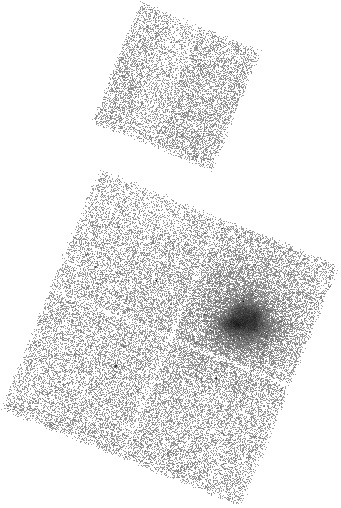

In [36]:
display < 542/primary/acisf00542N004_full_img2.jpg

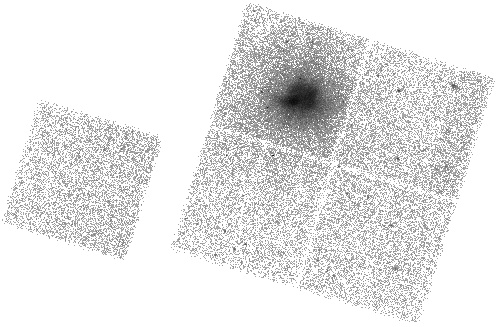

In [37]:
display < 3593/primary/acisf03593N003_full_img2.jpg

The `ROLL_PNT` is different between the two observations so the cluster is imaged at somewhat different off-axis
angles.

## Software Updates

In [2]:
dmlist true_early.fits"[cols ascdsver]" data,clean | sort | uniq -c

      1  7.6.10     
    280  8.1.1      
    185  8.1.2      
    131  8.2.1      
      5  8.3.2      
     41  8.3.2.1    
      5  8.3.3      
     10  8.3.3.1    
      3  8.3.4      
      1 #  ascdsver


In [4]:
dmlist true_early.fits"[ascdsver=7.6.10][cols date-obs,obs_id,object]" data,clean

#  date-obs               obs_id   object
 2000-01-06T15:02:09    751      1E 1207.4-5209                                       


In [5]:
dmlist true_early.fits"[ascdsver=8.3.4][cols date-obs,obs_id,object]" data,clean

#  date-obs               obs_id   object
 1999-11-06T01:10:13    400      NGC 4321                                             
 1999-12-30T01:51:49    378      M82                                                  
 2000-01-15T15:24:04    400      NGC 4321                                             


### Summary of relvant release notes

> **IMPORTANT**: The aspect changes may not be fully reflected in these notes but a best first-cut guess at the things  which definitely affect the event data have been included.

`8.3`
    - HRC time varying gain + new PI range
    - change calc of \_PNT and \_NOM in obidet
    - drop L2 HRC pha filter 

`8.3.3`
    - graded mode CTI
    - TGAIN added
    - ACIS-S + LETG calibrations (pixlib)

`8.4`
    - aspect periscope alignment drift
    - EDSER
    - remove celldetect in L2
    

`8.4.1`
    - obspar_ver=7 (Units in headers)
    - HRC msk1 files now include bpix edge.  Resulting in better fov1 files eg used by CDA footprint server.
    - various other places where keyword units have been corrected
    - FOV files when chips excluding all data now drops chip. (eg CasA, 214).
    
`8.4.2` 
    - acis_find_afterglow now used to ID hot/glow pixels|columns

`8.4.x`
    - Start Repro 4

---

`10.0`
    - L0: acis pbk0 file `WIND_ID` keyword incorrect
    - new `deltaoclk` tool feeds into `acis_format_events` affects PHAs.  Changes format of stat1.fits files
    - obidet updates to SCS107/RADMON-disable 
    - fix V&V aspect quarternion values 
   
`10.1`
    - tgdetect2 (tgfindzo) , aka piledup sources.  Updates meta data in L1.5+ used in V&V

`10.2`
    - fixes `MTLFILE` keyword in acis_evt1

`10.4.2`
    - a_p_e, t_r_e bootstrap for CC+gratings to get better time of arrivial
    - subpixel in CC mode
    - new `ORDER_ADJ` keyword in acis evt1a products

`10.4.2.1`
    - new CC mode event defs for evt1a files

`10.5.0.2`
    - remove TLMIN|MAX for bootstrap chipy_zo & chipy_tg
    - use NaN for bootstrap chipy_zo & chipy_tg
    
    

In [40]:
dmlist true_early.fits"[cols caldbver]" data,clean | sort | uniq -c


Failed to open virtual file true_early.fits[cols caldbver]
# DMLIST (CIAO 4.10): Column select syntax: unknown column caldbver


Poo.  The `CALDBVER` in the obspar files isn't guaranteed to be what was used in evt processing but should be close.  Definitely not before it.

Okay, let's grab the fov files and use it from there.

In [42]:
mkdir -p fovs

( cd fovs; \
  cat ../ocat.log | grep URL | awk '{print $3"/primary/*fov1.fits.gz"}' | \
  xargs -I@ wget -q "@" )


In [43]:
(cd fovs; \ls *fov1.fits.gz | xargs -I@ dmkeypar @ CALDBVER echo+ ) | sort | uniq -c 

      1 3.4.0
    173 4.1.4
      3 4.1.5
      1 4.1.7
      2 4.3.0
     12 4.3.1
     13 4.4.0
      1 4.4.3
      2 4.4.4


> So all CALDB updates after basically 4.1.4. 

`4.2.0`
    - tgain 2009-08-01 to 2009-10-31
    - contam ver 5 (post 2005(
    - hrc-i SAMP gain maps
    - hrc-s SMAP time-dependent gain maps

`4.2.1`
    - tgain 2009-11-01 through 2010-01-31
    - acis blank sky E 
    - LETG GREFFs 

`4.3.0`
    - tgain 2010-02-01 to 2010-04-30
    - hrc-i SAMP gamp post 2009-09-24
    - hrc-i background events
    - hrc-i background pi spectrum
 
`4.3.1`
    - tgain
    - acis-8 bkg (destreak)
    - gain, tgain, cti for 1999 ERs ** that's us **

`4.4.0`
    - grade image for CTI calibration.
    - tgain
    - geom updates for ACIS/LETG tilt

`4.4.1`
    - contam v6
    - EDSER subpixel
    - tgain
    - ACIS+LETG LSFPARAMs
    - HRC-I tgain
    - HRC-I QE v8
    - HRC-S SAMP rmfs
    
`4.4.3`
    - tgain
    - CTI post Jan 2000, +FP_TEMP range
    - LETG higher order eff
    
`4.4.4`
    - tgain x 2
    - gain (sans CTI)
    - pcad alignment corrections

?? Repro4 ??

`4.4.5`
    - time dependent HRC-S QEU

`4.4.6`
    - tgain
    - various gain, tgain, cti p2_resp, osip, fef, qe/u for +FP_TEMP post Jan 2000

`4.4.6.1`
    - HETG eff n0007

`4.4.7`
    - tgain
    - hrc-i gmaps
    - hrc-i bkgrnd pi spectrum
    - hrc-s QE

`4.4.8`
    - tgain

`4.4.9`
    - missing

`4.4.10`
    - tgain
    - contam v7
    

`4.5.0`
    - hrc gaplookup updates

`4.5.1`
    - hrc-s tgmap

`4.5.2`
    - tgain
    - acis blanksky E v2

`4.5.4`    
    - tgain for warm ERs
    - cti post Jan 2000
    - gain and osip for no-CTI


`4.5.5`
    - tgain
    - acis que
    - hrc-i gain map, pi bkg 
    - hrc-s qe
    - cti/gain for -110 ERs post Jan 2000
    
`4.5.6`
    - tgain
    - blank sky F
    - gain/cti files (wonky time period -- fp_temp incorrect)

`4.5.7`
    - tgain
    - blank F update
    - fix hrc-s t_gmap grating=NONE

`4.5.8`
    - tgain
    
`4.5.9`
    - tgain
    - comtam v8
    - hrc-i sampgain post 2013

`4.6.1`
    - tgain
    - bpix fix FP_TEMP secondary
    - hrc-i blanksky evt
    - hrc RMF

`4.6.2`
    - tgain
    - pcad align n0009 (post 2003)
    - contam v9
    
`4.6.3`
    - tgain
    - hrc-s qeu
    - hrc-i gmaps

`4.6.4`
    - grade file CC33_GRADED post 2009 update

`4.6.5`
    - tgain
    - grade file v5 
    - hrc-i gmaps
    - hrc-s qe/u
    
`4.6.7`
    - tgain
    
`4.6.8`
    - tgain + retro update

`4.6.9`
    - tain
    - detgain + p2resp for S1 (post 2000 Jan)
    - LETGS lSFPARAM
    - HRC-S QE
    - HRC-I QE

`4.6.10a`
    - EDSER update for CC mode

`4.7.0`
    - tgain
    - EDSER update for CC mode
    - QE for CC mode pre 2009
    - HRC-I gmap 
    - HRC-I pibkg
    - HRC-I bkgevt

`4.7.1`
    - tgain
    
`4.7.2`
    - retract grade file (c. `4.6.4`)
    - CC mode QE file selection

`4.7.3`
    - tgain x2
    - contam 10
    - hrc-i gmap
    - hrc-i pibkg

`4.7.4`
    - tgain
    - hrc-i que
    - hrc-s badpix v4 (note: bpix in mask; users can remake bpix but not msk1)
    - hrc-s qeu

`4.7.5`
    - t-cti for S3 (post 2000 Jan)

`4.7.5.1`
    - blanksky G

`4.7.6`
    - tgain x2
    - blanksky G v2

`4.7.7`
    - hrc-i gmap , bkg

`4.7.8`
    - tgain x2
    - hrc-s gaplookup

## Check the meta-data

In [14]:
download_chandra_obsid 378 evt1 
download_chandra_obsid 19678 evt1


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits        8 Mb  ####################          < 1 s  14108.5 kb/s


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits       61 Mb  ####################            2 s  39577.8 kb/s



In [15]:
dmlist 378/secondary/acisf00378_000N005_evt1.fits.gz header,clean | \
  egrep -v 'HISTORY|COMMENT' | awk '{print $1}' | sed 's,[0-9]$,,' | sort > 378.hdr

In [16]:
dmlist 19678/secondary/acisf19678_000N001_evt1.fits.gz header,clean | \
  egrep -v 'HISTORY|COMMENT' | awk '{print $1}' | sed 's,[0-9]$,,' | sort > 19678.hdr

In [17]:
diff 378.hdr 19678.hdr

42a43
> DTH_AVG
44c45,46
< EQUINOX
---
> DY_AVG
> DZ_AVG
51a54
> FEP_CCD
90a94
> OCLKPAIR
96a101
> ORC_MODE
100c105
< RADECSYS
---
> RADESYS
123a129,130
> SUBPIXFL
> SUM_2X
139a147
> TIME_ADJ


#### Issues

1. Obsolete WCS convention:  `EQUINOX` and `RADECSYS`
2. Missing mean aimpoint offset (`DY_AVG`, `DZ_AVG`, `DTH_AVG`) used by various tools including `dmcoords`, `mkarf`, etc.
3. Missing parameter block info ( `FEP_CCD`, `OCLKPAIR`, `ORC_MODE`, and `SUM_2x2`) use for dead-area calibrations.
4. Not using `EDSER` subpixel algorithm.
5. Not using CC time of arrival algorithm.


### Take a look at the keyword descriptions

This is kinda messy, but the gist is that the units and descriptions of data has changed.

In [24]:
dmmakepar 378/secondary/acisf00378_000N005_evt1.fits.gz"[EVENTS]" 378_hdr.par clob+
dmmakepar 19678/secondary/acisf19678_000N001_evt1.fits.gz"[events]" 19678_hdr.par clob+

In [25]:
# Blank out the values, we only want to see the comments here.

sort 19678_hdr.par > 19678_hdr_sorted.par
pdump 19678_hdr.par | egrep -v EOF | cut -d= -f1 | egrep -v 'clockapp|cti_corr' | xargs -I@ pset 19678_hdr_sorted @=""

In [20]:
# Blank out the values, we only want to see the comments here.

sort 378_hdr.par > 378_hdr_sorted.par
pdump 378_hdr.par | egrep -v EOF | cut -d= -f1 | egrep -v 'clockapp|cti_corr' | xargs -I@ pset 378_hdr_sorted @=""

In [23]:
sdiff 378_hdr_sorted.par 19678_hdr_sorted.par

acsys1,s,h,"",,,"reference for chip coord system"		acsys1,s,h,"",,,"reference for chip coord system"
acsys2,s,h,"",,,"reference for tiled detector coord system"	acsys2,s,h,"",,,"reference for tiled detector coord system"
acsys3,s,h,"",,,"reference for focal plane coord system"	acsys3,s,h,"",,,"reference for focal plane coord system"
acsys4,s,h,"",,,"reference for sky coord system"		acsys4,s,h,"",,,"reference for sky coord system"
aimpfile,s,h,"",,,						aimpfile,s,h,"",,,
ascdsver,s,h,"",,,"ASCDS version number"		      |	ascdsver,s,h,"",,,"Processing system revision"
asolfile,s,h,"",,,						asolfile,s,h,"",,,
asptype,s,h,"",,,						asptype,s,h,"",,,
biasfil0,s,h,"",,,"bias file used: CCD 0"			biasfil0,s,h,"",,,"bias file used: CCD 0"
biasfil1,s,h,"",,,"bias file used: CCD 1"			biasfil1,s,h,"",,,"bias file used: CCD 1"
biasfil2,s,h,"",,,"bias file used: CCD 2"			biasfil2,s,h,"",,,"bias file used: CCD 2"
biasfil3,s,h,"",,,"bias file used: CCD 3"			biasfil3,s,h,"",,,"bias file used: CCD 3